# Training Tensorflow Hub
Entrainement des modèles TensorFlow Hub Resnet50 3 bandes pour café contre reste et culture contre non-culture

* Romain Capocasale
* IADeforestation
* HES-SO MASTER


# Import

In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv
import tensorflow_hub as hub

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Conv2D, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from shapely import wkt
from keras import backend as K 


from IAdeforestation.tools import *
from IAdeforestation.training import *
from IAdeforestation.evaluation import *

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Check if GPU device is available

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4226359160206054868
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7570064672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11569480719119453304
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join("saved_models", "tensowflow_hub")

# Create model

In [4]:
def create_model():
    model = Sequential()
    model.add(Input(2048))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Coffee vs Other

In [2]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1", tags=['train'], input_shape=(64,64,3))

In [3]:
hub_layer

## Stratified cross-val

In [3]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

### Compute class weight

In [4]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 2.07035175879397, 1: 0.6592}

### Train model

In [22]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'strat_coffee_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [23]:
fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = keras_layer_generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'][1:4], 
                                  eurosat_params['std'][1:4], 
                                hub_layer,
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = keras_layer_generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'][1:4], 
                                eurosat_params['std'][1:4],
                                hub_layer,
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1


Epoch 1/100
60/60 [==============================] - 9s 141ms/step - loss: 1.6047 - accuracy: 0.4546 - precision: 0.2379 - recall: 0.6291 - val_loss: 1.1570 - val_accuracy: 0.4719 - val_precision: 0.2819 - val_recall: 0.9143
Epoch 2/100
60/60 [==============================] - 8s 130ms/step - loss: 1.5565 - accuracy: 0.4955 - precision: 0.2813 - recall: 0.5816 - val_loss: 1.0464 - val_accuracy: 0.5500 - val_precision: 0.3138 - val_recall: 0.7973
Epoch 3/100
60/60 [==============================] - 8s 136ms/step - loss: 1.3869 - accuracy: 0.5367 - precision: 0.2870 - recall: 0.6147 - val_loss: 0.9522 - val_accuracy: 0.6062 - val_precision: 0.3989 - val_recall: 0.8202
Epoch 4/100
60/60 [==============================] - 8s 132ms/step - loss: 1.3251 - accuracy: 0.5443 - precision: 0.2729 - recall: 0.5888 - val_loss: 0.9292 - val_accuracy: 0.6406 - val_precision: 0.3704 - val_recall: 0.8219
Epoch 5/100
60/60 [==============================] - 8s 138ms/step - loss: 1.3169 - accuracy: 0.5708

60/60 [==============================] - 8s 140ms/step - loss: 0.8481 - accuracy: 0.7430 - precision: 0.4947 - recall: 0.7822 - val_loss: 0.7390 - val_accuracy: 0.7625 - val_precision: 0.4846 - val_recall: 0.8750
Epoch 74/100
60/60 [==============================] - 8s 139ms/step - loss: 0.8119 - accuracy: 0.7439 - precision: 0.4812 - recall: 0.7653 - val_loss: 0.7184 - val_accuracy: 0.7688 - val_precision: 0.5000 - val_recall: 0.8649
Epoch 75/100
60/60 [==============================] - 8s 138ms/step - loss: 0.7951 - accuracy: 0.7473 - precision: 0.4745 - recall: 0.7798 - val_loss: 0.7066 - val_accuracy: 0.7969 - val_precision: 0.5462 - val_recall: 0.8553
Epoch 76/100
60/60 [==============================] - 8s 140ms/step - loss: 0.8032 - accuracy: 0.7514 - precision: 0.4960 - recall: 0.7799 - val_loss: 0.7409 - val_accuracy: 0.7719 - val_precision: 0.5424 - val_recall: 0.7711
Epoch 77/100
60/60 [==============================] - 8s 138ms/step - loss: 0.8338 - accuracy: 0.7446 - preci

60/60 [==============================] - 8s 140ms/step - loss: 0.8921 - accuracy: 0.7347 - precision: 0.4523 - recall: 0.7368 - val_loss: 0.7463 - val_accuracy: 0.7875 - val_precision: 0.5659 - val_recall: 0.8588
Epoch 45/100
60/60 [==============================] - 8s 138ms/step - loss: 0.8699 - accuracy: 0.7402 - precision: 0.4841 - recall: 0.7449 - val_loss: 0.7074 - val_accuracy: 0.8094 - val_precision: 0.5794 - val_recall: 0.9012
Epoch 46/100
60/60 [==============================] - 8s 139ms/step - loss: 0.8793 - accuracy: 0.7303 - precision: 0.4421 - recall: 0.7335 - val_loss: 0.7231 - val_accuracy: 0.7875 - val_precision: 0.4960 - val_recall: 0.9254
Epoch 47/100
60/60 [==============================] - 8s 138ms/step - loss: 0.8890 - accuracy: 0.7220 - precision: 0.4314 - recall: 0.6943 - val_loss: 0.7667 - val_accuracy: 0.7437 - val_precision: 0.4762 - val_recall: 0.7895
Epoch 48/100
60/60 [==============================] - 8s 140ms/step - loss: 0.8941 - accuracy: 0.7285 - preci

60/60 [==============================] - 9s 144ms/step - loss: 1.0352 - accuracy: 0.6432 - precision: 0.3806 - recall: 0.6699 - val_loss: 0.7712 - val_accuracy: 0.7844 - val_precision: 0.5268 - val_recall: 0.7867
Epoch 16/100
60/60 [==============================] - 8s 140ms/step - loss: 1.0579 - accuracy: 0.6186 - precision: 0.3520 - recall: 0.6429 - val_loss: 0.7740 - val_accuracy: 0.7688 - val_precision: 0.5586 - val_recall: 0.7126
Epoch 17/100
60/60 [==============================] - 8s 139ms/step - loss: 1.0111 - accuracy: 0.6474 - precision: 0.3756 - recall: 0.6997 - val_loss: 0.7897 - val_accuracy: 0.7812 - val_precision: 0.5370 - val_recall: 0.7436
Epoch 18/100
60/60 [==============================] - 8s 139ms/step - loss: 1.0376 - accuracy: 0.6530 - precision: 0.4048 - recall: 0.6683 - val_loss: 0.7775 - val_accuracy: 0.7469 - val_precision: 0.5688 - val_recall: 0.6458
Epoch 19/100
60/60 [==============================] - 8s 139ms/step - loss: 1.0306 - accuracy: 0.6540 - preci

60/60 [==============================] - 8s 142ms/step - loss: 0.7914 - accuracy: 0.7626 - precision: 0.5066 - recall: 0.7569 - val_loss: 0.7051 - val_accuracy: 0.8000 - val_precision: 0.5607 - val_recall: 0.7792
Epoch 88/100
60/60 [==============================] - 8s 137ms/step - loss: 0.8055 - accuracy: 0.7452 - precision: 0.4814 - recall: 0.7441 - val_loss: 0.7066 - val_accuracy: 0.8094 - val_precision: 0.6050 - val_recall: 0.8372
Epoch 89/100
60/60 [==============================] - 8s 140ms/step - loss: 0.7604 - accuracy: 0.7548 - precision: 0.4884 - recall: 0.8049 - val_loss: 0.6873 - val_accuracy: 0.7969 - val_precision: 0.5826 - val_recall: 0.7976
Epoch 90/100
60/60 [==============================] - 8s 140ms/step - loss: 0.8253 - accuracy: 0.7451 - precision: 0.4632 - recall: 0.7919 - val_loss: 0.7214 - val_accuracy: 0.7625 - val_precision: 0.4912 - val_recall: 0.7568
Epoch 91/100
60/60 [==============================] - 8s 136ms/step - loss: 0.7974 - accuracy: 0.7503 - preci

60/60 [==============================] - 8s 140ms/step - loss: 0.8615 - accuracy: 0.7399 - precision: 0.4915 - recall: 0.7807 - val_loss: 0.7410 - val_accuracy: 0.7531 - val_precision: 0.5285 - val_recall: 0.7558
Epoch 59/100
60/60 [==============================] - 8s 138ms/step - loss: 0.8471 - accuracy: 0.7328 - precision: 0.4634 - recall: 0.7683 - val_loss: 0.6963 - val_accuracy: 0.8000 - val_precision: 0.5446 - val_recall: 0.8243
Epoch 60/100
60/60 [==============================] - 8s 140ms/step - loss: 0.8524 - accuracy: 0.7276 - precision: 0.4567 - recall: 0.7473 - val_loss: 0.7439 - val_accuracy: 0.7750 - val_precision: 0.5083 - val_recall: 0.8243
Epoch 61/100
60/60 [==============================] - 8s 140ms/step - loss: 0.8938 - accuracy: 0.7218 - precision: 0.4420 - recall: 0.7341 - val_loss: 0.7250 - val_accuracy: 0.7750 - val_precision: 0.5289 - val_recall: 0.8101
Epoch 62/100
60/60 [==============================] - 8s 138ms/step - loss: 0.8237 - accuracy: 0.7498 - preci

60/60 [==============================] - 8s 138ms/step - loss: 0.8786 - accuracy: 0.7090 - precision: 0.4298 - recall: 0.7303 - val_loss: 0.9091 - val_accuracy: 0.6562 - val_precision: 0.4235 - val_recall: 0.8571
Epoch 30/100
60/60 [==============================] - 8s 141ms/step - loss: 0.9149 - accuracy: 0.7062 - precision: 0.4210 - recall: 0.7203 - val_loss: 0.9153 - val_accuracy: 0.6562 - val_precision: 0.3810 - val_recall: 0.9143
Epoch 31/100
60/60 [==============================] - 8s 137ms/step - loss: 0.9171 - accuracy: 0.7165 - precision: 0.4522 - recall: 0.7284 - val_loss: 0.8879 - val_accuracy: 0.6812 - val_precision: 0.4062 - val_recall: 0.9028
Epoch 32/100
60/60 [==============================] - 8s 140ms/step - loss: 0.9341 - accuracy: 0.7071 - precision: 0.4306 - recall: 0.7316 - val_loss: 0.8684 - val_accuracy: 0.6969 - val_precision: 0.4383 - val_recall: 0.9221
Epoch 33/100
60/60 [==============================] - 8s 140ms/step - loss: 0.9247 - accuracy: 0.7119 - preci

4/4 [==============================] - 0s 117ms/step - loss: 0.8045 - accuracy: 0.7031 - precision: 0.4480 - recall: 0.8889
Fold 4 loss : 0.8045076131820679
Fold 4 accuracy : 0.703125
Fold 4 F1-score : 0.5957446945649889




In [24]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.75703125
Stdev accuracy : 0.03435723973015003


Mean loss : 0.7369965076446533
Stdev loss : 0.03608276559469389


Mean precision : 0.4922779679298401
Stdev precision : 0.05833952350526799


Mean recall : 0.839723002910614
Stdev recall : 0.045243130642182626


Mean F1-Score : 0.6173366438772708
Stdev F1-Score : 0.043617355418208575


In [25]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

## Loss and accs plots

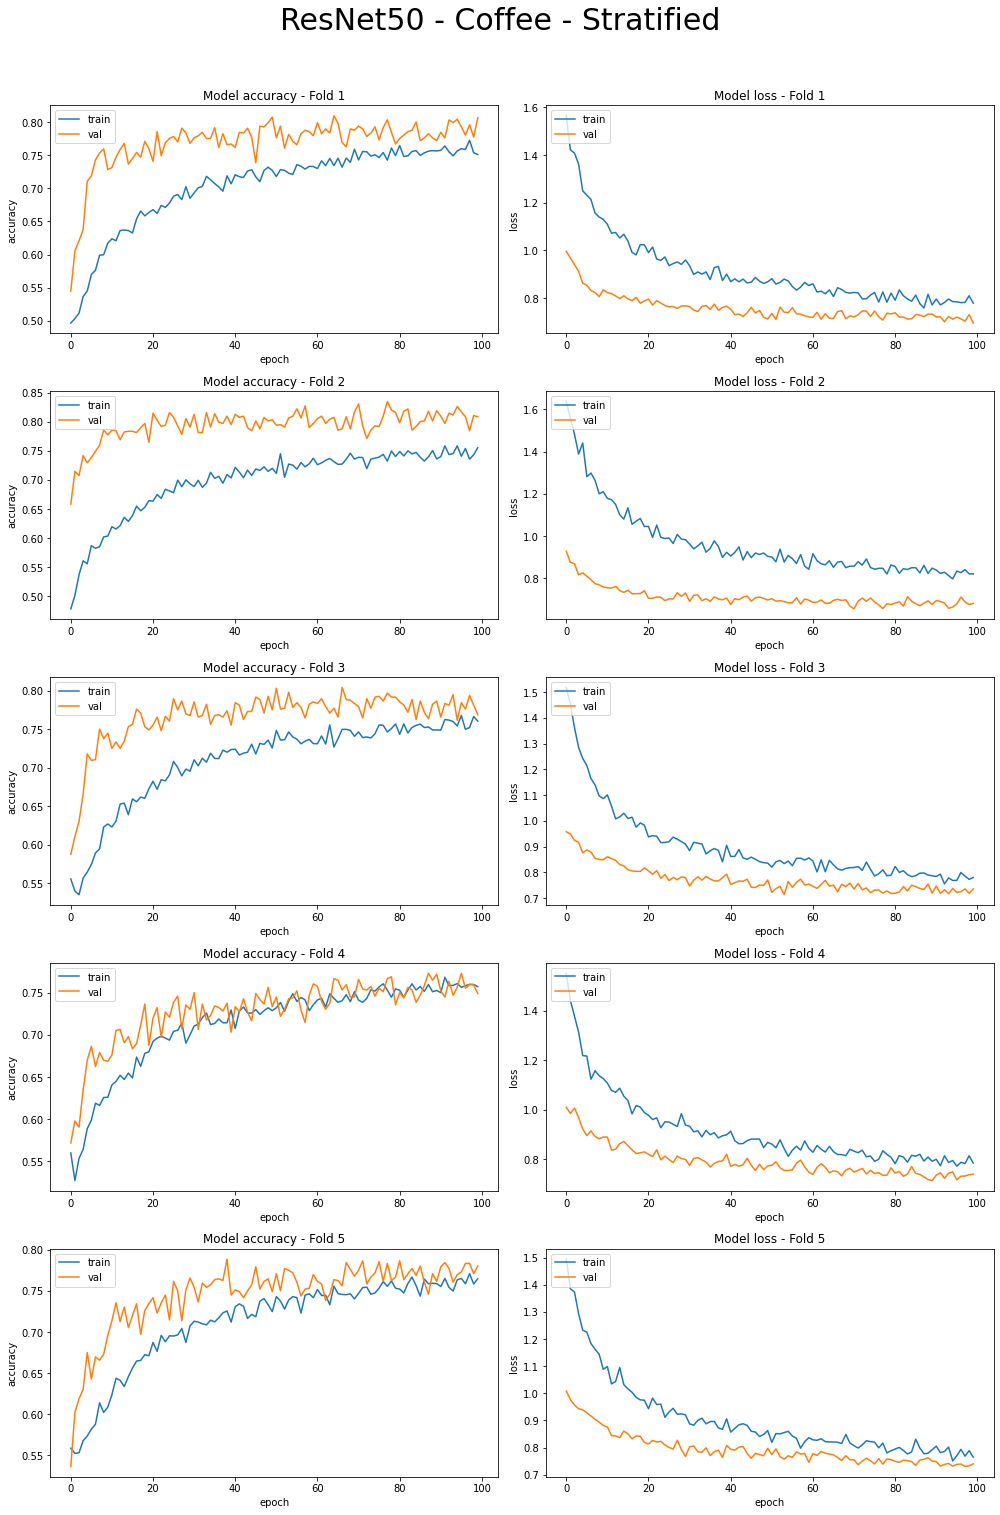

In [4]:
path = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'strat_coffee_2')
plot_acc_loss(path, "ResNet50 - Coffee - Stratified")

# Culture vs No culture

## Stratified Cross val

In [7]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'strat_train_culture_32.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

## Train model

In [8]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_32_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [9]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = keras_layer_generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'][1:4], 
                                  eurosat_params['std'][1:4], 
                                hub_layer,
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = keras_layer_generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'][1:4], 
                                eurosat_params['std'][1:4],
                                hub_layer,
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
70/70 [==============================] - 10s 132ms/step - loss: 1.5851 - accuracy: 0.5301 - precision: 0.4794 - recall: 0.4710 - val_loss: 0.8291 - val_accuracy: 0.7656 - val_precision: 0.7370 - val_recall: 0.7068
Epoch 2/100
70/70 [==============================] - 9s 126ms/step - loss: 1.2151 - accuracy: 0.6338 - precision: 0.5850 - recall: 0.5905 - val_loss: 0.7662 - val_accuracy: 0.7979 - val_precision: 0.7654 - val_recall: 0.7494acy: 0.6286 - precision: 0.57
Epoch 3/100
70/70 [==============================] - 9s 127ms/step - loss: 1.1077 - accuracy: 0.6694 - precision: 0.6397 - recall: 0.6165 - val_loss: 0.7587 - val_accuracy: 0.7998 - val_precision: 0.8017 - val_recall: 0.7705
Epoch 4/100
70/70 [==============================] - 9s 127ms/step - loss: 1.0272 - accuracy: 0.7063 - precision: 0.6578 - recall: 0.7005 - val_loss: 0.7272 - val_accuracy: 0.8145 - val_precision: 0.7991 - val_recall: 0.7668
Epoch 5/100
70/70 [==============================] - 9s 128ms/step - l

70/70 [==============================] - 9s 129ms/step - loss: 0.5970 - accuracy: 0.8301 - precision: 0.8188 - recall: 0.7922 - val_loss: 0.5588 - val_accuracy: 0.8613 - val_precision: 0.8716 - val_recall: 0.7968
Epoch 74/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6308 - accuracy: 0.8066 - precision: 0.7875 - recall: 0.7690 - val_loss: 0.5613 - val_accuracy: 0.8408 - val_precision: 0.8741 - val_recall: 0.7543
Epoch 75/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6134 - accuracy: 0.8140 - precision: 0.8213 - recall: 0.7498 - val_loss: 0.5632 - val_accuracy: 0.8418 - val_precision: 0.8635 - val_recall: 0.7648
Epoch 76/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6059 - accuracy: 0.8230 - precision: 0.8318 - recall: 0.7678 - val_loss: 0.5443 - val_accuracy: 0.8516 - val_precision: 0.8879 - val_recall: 0.7902
Epoch 77/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6139 - accuracy: 0.8221 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.6706 - accuracy: 0.8118 - precision: 0.8077 - recall: 0.7628 - val_loss: 0.6143 - val_accuracy: 0.8545 - val_precision: 0.9310 - val_recall: 0.7405
Epoch 45/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6825 - accuracy: 0.8099 - precision: 0.8071 - recall: 0.7505 - val_loss: 0.6045 - val_accuracy: 0.8330 - val_precision: 0.9128 - val_recall: 0.7068
Epoch 46/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6767 - accuracy: 0.8038 - precision: 0.8012 - recall: 0.7563 - val_loss: 0.6029 - val_accuracy: 0.8369 - val_precision: 0.8862 - val_recall: 0.7298
Epoch 47/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6771 - accuracy: 0.8133 - precision: 0.8302 - recall: 0.7501 - val_loss: 0.5919 - val_accuracy: 0.8506 - val_precision: 0.8776 - val_recall: 0.7607
Epoch 48/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6535 - accuracy: 0.8261 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.6691 - accuracy: 0.8181 - precision: 0.8155 - recall: 0.7706 - val_loss: 0.6192 - val_accuracy: 0.8271 - val_precision: 0.8555 - val_recall: 0.7703
Epoch 45/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6479 - accuracy: 0.8203 - precision: 0.8077 - recall: 0.7755 - val_loss: 0.6137 - val_accuracy: 0.8340 - val_precision: 0.8231 - val_recall: 0.7860
Epoch 46/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6399 - accuracy: 0.8277 - precision: 0.8323 - recall: 0.7808 - val_loss: 0.5812 - val_accuracy: 0.8418 - val_precision: 0.8538 - val_recall: 0.7880
Epoch 47/100
70/70 [==============================] - 9s 129ms/step - loss: 0.6408 - accuracy: 0.8234 - precision: 0.8256 - recall: 0.7663 - val_loss: 0.6078 - val_accuracy: 0.8193 - val_precision: 0.8278 - val_recall: 0.7780
Epoch 48/100
70/70 [==============================] - 9s 130ms/step - loss: 0.6505 - accuracy: 0.8239 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.7814 - accuracy: 0.7830 - precision: 0.7647 - recall: 0.7420 - val_loss: 0.7198 - val_accuracy: 0.7988 - val_precision: 0.8470 - val_recall: 0.6739
Epoch 16/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7647 - accuracy: 0.7875 - precision: 0.7853 - recall: 0.7430 - val_loss: 0.6985 - val_accuracy: 0.8154 - val_precision: 0.8535 - val_recall: 0.7155
Epoch 17/100
70/70 [==============================] - 9s 130ms/step - loss: 0.7518 - accuracy: 0.7971 - precision: 0.7802 - recall: 0.7545 - val_loss: 0.7147 - val_accuracy: 0.8096 - val_precision: 0.8787 - val_recall: 0.6849
Epoch 18/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7796 - accuracy: 0.7797 - precision: 0.7556 - recall: 0.7508 - val_loss: 0.7082 - val_accuracy: 0.8105 - val_precision: 0.8800 - val_recall: 0.7068
Epoch 19/100
70/70 [==============================] - 9s 129ms/step - loss: 0.7458 - accuracy: 0.7959 - preci

70/70 [==============================] - 9s 129ms/step - loss: 0.5585 - accuracy: 0.8335 - precision: 0.8600 - recall: 0.7663 - val_loss: 0.5611 - val_accuracy: 0.8213 - val_precision: 0.8690 - val_recall: 0.7248
Epoch 88/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5501 - accuracy: 0.8434 - precision: 0.8341 - recall: 0.8026 - val_loss: 0.5403 - val_accuracy: 0.8486 - val_precision: 0.9305 - val_recall: 0.7296
Epoch 89/100
70/70 [==============================] - 9s 130ms/step - loss: 0.5689 - accuracy: 0.8328 - precision: 0.8527 - recall: 0.7700 - val_loss: 0.5529 - val_accuracy: 0.8447 - val_precision: 0.9019 - val_recall: 0.7291
Epoch 90/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5400 - accuracy: 0.8436 - precision: 0.8638 - recall: 0.7727 - val_loss: 0.5703 - val_accuracy: 0.8174 - val_precision: 0.8436 - val_recall: 0.7231
Epoch 91/100
70/70 [==============================] - 9s 129ms/step - loss: 0.5581 - accuracy: 0.8226 - preci

In [10]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.8421875
Stdev accuracy : 0.028874560332150512


Mean loss : 0.5812037765979767
Stdev loss : 0.09212604479674416


Mean precision : 0.8728580355644227
Stdev precision : 0.03476147047396918


Mean recall : 0.764775276184082
Stdev recall : 0.0583547704819978


Mean F1-Score : 0.8140180476198997
Stdev F1-Score : 0.03828002179382775


In [11]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

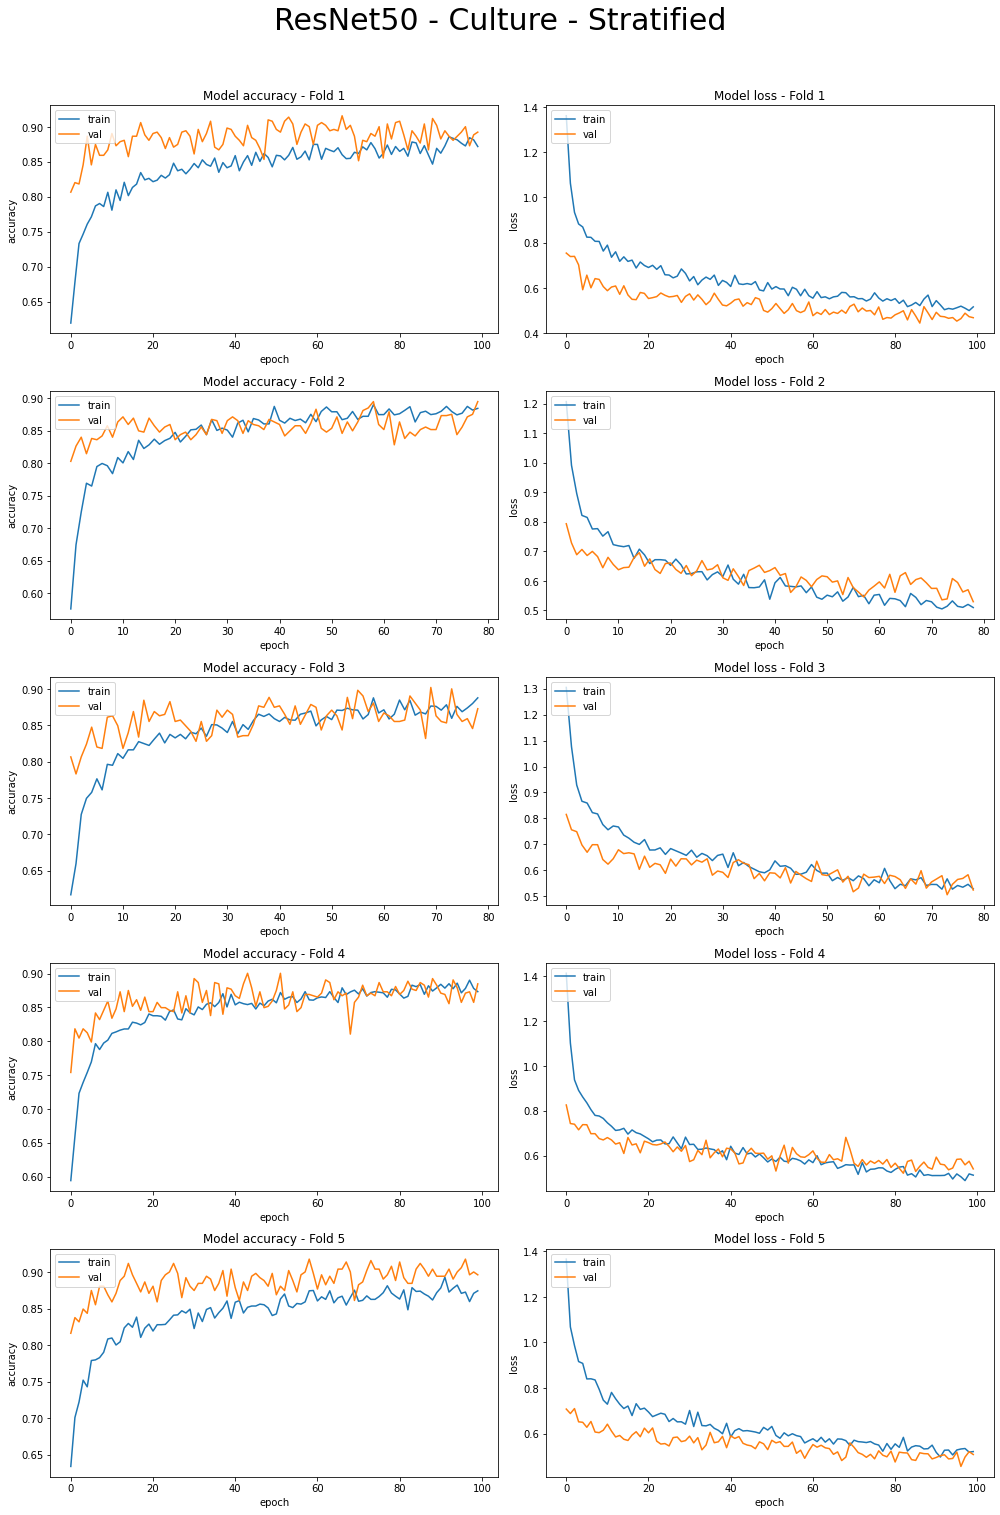

In [5]:
path = os.path.join(SAVED_MODELS_PATH, 'Culture', 'strat_culture_1')
plot_acc_loss(path, "ResNet50 - Culture - Stratified")